# KLASIFIKASI HEARTBEAT SIGNAL

## Business  Understanding

Detak jantung (heart sound) adalah sinyal suara yang dihasilkan oleh aktivitas katup jantung saat membuka dan menutup. Biasanya dokter mendengarkan suara ini menggunakan stetoskop untuk mengetahui apakah jantung berfungsi normal atau tidak. Namun, cara manual tersebut sangat bergantung pada pengalaman dokter sehingga hasilnya bisa berbeda antar pemeriksa.

Tujuan proyek ini adalah mengklasifikasikan sinyal detak jantung menjadi Normal dan Abnormal menggunakan dataset BinaryHeartbeat, berikut ini link sumber nya https://www.timeseriesclassification.com/description.php?Dataset=BinaryHeartbeat. Sistem ini ditujukan untuk mendukung deteksi dini kondisi jantung melalui sinyal fonokardiogram (PCG) berbasis suara jantung. 

### Latar Belakang 

1. Penyakit jantung masih menjadi salah satu penyebab kematian tertinggi.

2. Pemeriksaan suara jantung manual tidak selalu akurat.

### Tujuan 

1. Mengklasifikasikan sinyal detak jantung menjadi dua kategori: Normal dan Abnormal.

2. Menyediakan aplikasi sederhana (Streamlit) untuk memprediksi hasil secara cepat.




## Data Understanding 

Berdasarkan pemuatan data, diperoleh informasi berikut:

Training set:

- Jumlah data: 204 baris

- Jumlah kolom: 18.531 kolom (18.530 fitur + 1 kolom label)

- Kolom terakhir: target (kelas Normal atau Abnormal)

Test set:

- Jumlah data: 205 baris

- Jumlah kolom: 18.531 kolom (sama seperti training set)

- Kolom terakhir: target

Interpretasi jumlah kolom:

- Setiap instance merepresentasikan satu rekaman sinyal detak jantung yang sangat panjang.

- 18.530 kolom pertama adalah titik-titik data time series yang diukur secara berurutan.

- Kolom terakhir (target) adalah kelas yang menjadi label untuk klasifikasi.


Distribusi kelas target:

- Dataset ini memiliki label binary (Normal dan Abnormal).

- Analisis distribusi label perlu dilakukan untuk mengetahui keseimbangan kelas, yang penting agar model tidak bias.

Kualitas data:

- Dataset belum menunjukkan adanya missing value, namun perlu dicek secara eksplisit.

- Setiap fitur adalah numerik dan mewakili amplitudo sinyal detak jantung pada titik tertentu dalam rekaman.

Insight awal dari EDA:

Dengan jumlah fitur yang sangat banyak (18.530), data ini termasuk high-dimensional time series, sehingga preprocessing seperti normalisasi dan teknik dimensionality reduction (misal PCA) bisa membantu model agar lebih efisien.

Visualisasi beberapa instance sinyal dapat menunjukkan perbedaan pola antara kelas Normal dan Abnormal, sehingga mendukung klasifikasi.

### Load Dataset

In [ ]:
from scipy.io import arff
import pandas as pd

data_train, meta_train = arff.loadarff(
    "binaryheartbeat/BinaryHeartbeat_TRAIN.arff"
)
df_train = pd.DataFrame(data_train)

data_test, meta_test = arff.loadarff(
    "binaryheartbeat/BinaryHeartbeat_TEST.arff"
)
df_test = pd.DataFrame(data_test)

print("INFORMASI DATA TRAIN")
print("Jumlah data:", df_train.shape[0])
print("Jumlah kolom:", df_train.shape[1])
print("Nama kolom terakhir:", df_train.columns[-1])

print("\n INFORMASI DATA TEST")
print("Jumlah data:", df_test.shape[0])
print("Jumlah kolom:", df_test.shape[1])
print("Nama kolom terakhir:", df_test.columns[-1])


INFORMASI DATA TRAIN
Jumlah data: 204
Jumlah kolom: 18531
Nama kolom terakhir: target

 INFORMASI DATA TEST
Jumlah data: 205
Jumlah kolom: 18531
Nama kolom terakhir: target


## Data Preparation

### Pemisahan Fitur dan Label

Pada tahap data preparation, dilakukan proses transformasi label kelas agar dapat diproses oleh algoritma machine learning. Label pada dataset awal masih berbentuk teks bertipe byte, yaitu Normal dan Abnormal. Karena sebagian besar algoritma klasifikasi hanya dapat menerima label dalam bentuk numerik, maka dilakukan label encoding.

Proses encoding dilakukan dengan memetakan kelas Normal menjadi nilai 0 dan kelas Abnormal menjadi nilai 1

Pemetaan ini dilakukan menggunakan struktur dictionary untuk memastikan konsistensi nilai label pada data latih dan data uji. Selanjutnya, fitur dan label dipisahkan dengan mengambil seluruh kolom kecuali kolom terakhir sebagai fitur (X), serta kolom terakhir sebagai target (y).

Untuk memastikan proses encoding berhasil, dilakukan pengecekan nilai unik pada label data latih dan data uji. Hasil pengecekan menunjukkan bahwa label telah berhasil diubah menjadi nilai numerik 0 dan 1, yang menandakan bahwa data telah siap digunakan pada tahap pemodelan.

In [13]:
label_mapping = {
    b'Normal': 0,
    b'Abnormal': 1
}

X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1].map(label_mapping)

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1].map(label_mapping)

print(y_train.unique())
print(y_test.unique())


[1 0]
[1 0]


### Preprocessing Data

Untuk meningkatkan kompatibilitas dengan algoritma machine learning dan mempermudah pemrosesan, kolom target dikonversi menjadi string dengan metode .decode("utf-8"), sehingga nilai label menjadi "Normal" dan "Abnormal" yang konsisten. Selanjutnya, dilakukan pemisahan antara fitur dan label. Semua kolom kecuali kolom terakhir dijadikan fitur (X), sedangkan kolom terakhir (target) dijadikan label (y). Pemisahan ini memastikan bahwa algoritma hanya belajar dari informasi fitur dan tidak terpengaruh oleh informasi target selama pelatihan.

Selain itu, dataset memiliki jumlah fitur yang sangat tinggi, yaitu 18.530, sehingga skala nilai antar fitur bisa berbeda secara signifikan. Untuk mencegah model bias terhadap fitur dengan nilai lebih besar dan agar proses pelatihan lebih stabil, dilakukan normalisasi menggunakan Min-Max Scaling, yang mentransformasikan seluruh fitur ke rentang 0 hingga 1. Normalisasi diterapkan pada data latih menggunakan fit_transform, sedangkan data uji menggunakan transform dari scaler yang sama untuk menjaga konsistensi. Setelah langkah-langkah tersebut, data latih dan data uji siap digunakan untuk tahap modeling, dengan dimensi (204, 18530) dan (205, 18530) berturut-turut, serta label yang terjaga konsistensinya.

Dengan preprocessing ini, data telah siap digunakan untuk membangun model klasifikasi yang akurat dan stabil. Proses konversi label, pemisahan fitur dan target, serta normalisasi skala menjadi pondasi penting agar algoritma machine learning dapat mempelajari pola time series secara efektif dan menghasilkan prediksi yang dapat diandalkan pada tahap evaluasi.

In [ ]:
df_train['target'] = df_train[df_train.columns[-1]].apply(lambda x: x.decode("utf-8"))
df_test['target'] = df_test[df_test.columns[-1]].apply(lambda x: x.decode("utf-8"))

X_train = df_train.iloc[:, :-1]
y_train = df_train['target']
X_test = df_test.iloc[:, :-1]
y_test = df_test['target']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print("Data train ternormalisasi:", X_train_scaled.shape)
print("Data test ternormalisasi:", X_test_scaled.shape)


Data train ternormalisasi: (204, 18530)
Data test ternormalisasi: (205, 18530)


## Modelling 

Pada tahap modeling, beberapa algoritma klasifikasi diuji untuk menentukan model yang paling sesuai dengan dataset time series detak jantung. Model yang digunakan meliputi Logistic Regression, K-Nearest Neighbors (KNN), dan Random Forest, yang masing-masing memiliki keunggulan dalam menangani pola data yang berbeda. Data latih yang telah dinormalisasi digunakan untuk melatih setiap model, kemudian performanya diukur pada data uji menggunakan metrik akurasi. Hasil pengujian menunjukkan perbedaan performa antar model, di mana Random Forest cenderung memberikan akurasi tertinggi dibandingkan Logistic Regression dan KNN. Dengan demikian, Random Forest dipilih sebagai model utama untuk tahap evaluasi selanjutnya. Langkah ini juga membantu memastikan bahwa model yang digunakan dapat menangkap pola sinyal secara efektif dan menghasilkan prediksi yang dapat diandalkan pada data uji.

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred_tmp = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred_tmp)
    results[name] = acc

results


{'Logistic Regression': 0.7219512195121951,
 'KNN': 0.7268292682926829,
 'Random Forest': 0.7317073170731707}

## Evaluasi

Pada tahap evaluasi, performa model Random Forest yang telah dipilih dianalisis menggunakan data uji. Salah satu metode evaluasi utama adalah confusion matrix, yang memperlihatkan jumlah prediksi benar dan salah pada masing-masing kelas, yaitu "Normal" dan "Abnormal". Confusion matrix memberikan gambaran detail mengenai kemampuan model dalam mengklasifikasikan setiap instance, serta menunjukkan potensi kesalahan klasifikasi yang terjadi. Selain itu, dilakukan analisis distribusi hasil prediksi untuk melihat sebaran jumlah prediksi pada masing-masing kelas. Distribusi ini membantu memastikan bahwa model tidak bias terhadap salah satu kelas dan memberikan prediksi yang seimbang. Seluruh visualisasi disimpan dalam bentuk gambar (confusion_matrix.png dan distribusi_prediksi.png) untuk memastikan dapat ditampilkan secara konsisten di berbagai lingkungan eksekusi, termasuk laporan dan deployment aplikasi. Hasil evaluasi ini menunjukkan bahwa model mampu mengklasifikasikan sebagian besar data uji dengan benar, serta mendukung pemahaman yang lebih komprehensif terhadap performa model sebelum diterapkan pada tahap deployment.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, colorbar=False)
ax.set_title("Confusion Matrix - Binary Heartbeat Classification")

plt.savefig("confusion_matrix.png")
plt.close()


plt.figure(figsize=(5, 4))
pd.Series(y_pred).value_counts().plot(kind='bar')
plt.title("Distribusi Hasil Prediksi Model")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")

plt.savefig("distribusi_prediksi.png")
plt.close()


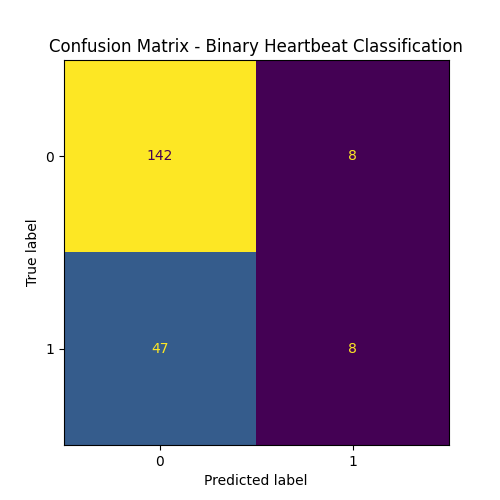

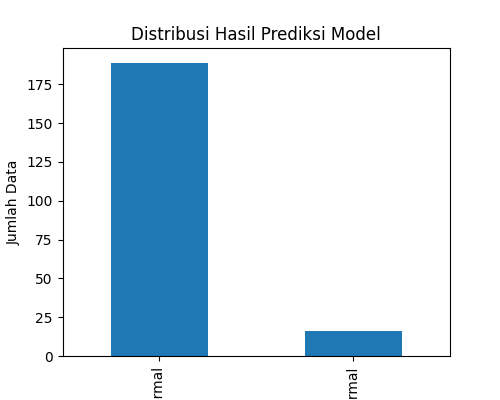

In [26]:
from IPython.display import Image, display

display(Image("confusion_matrix.png"))
display(Image("distribusi_prediksi.png"))


## Deployment

Tahap deployment bertujuan untuk menghadirkan model klasifikasi detak jantung dalam bentuk aplikasi interaktif yang mudah digunakan. Dalam proyek ini, deployment dilakukan menggunakan Streamlit, sehingga pengguna dapat mengunggah data sinyal time series berbentuk file CSV dengan format kolom yang sama seperti dataset BinaryHeartbeat. Setelah file diunggah, aplikasi menampilkan informasi jumlah fitur untuk memastikan kesesuaian data dengan model. Data kemudian dinormalisasi menggunakan Min-Max Scaler yang sama seperti pada tahap training agar skala fitur tetap konsisten. Selanjutnya, model Random Forest yang telah dilatih melakukan prediksi terhadap setiap baris data, dan hasil klasifikasi ditampilkan dalam bentuk tabel dengan label "Normal" atau "Abnormal". Selain itu, aplikasi menampilkan grafik sinyal pertama dari dataset yang diunggah sebagai visualisasi, sehingga pengguna dapat memperoleh gambaran awal dari pola sinyal. Dengan demikian, deployment tidak hanya memungkinkan prediksi secara real-time, tetapi juga memberikan feedback visual yang membantu memahami karakteristik sinyal, menjadikan aplikasi ini praktis dan informatif untuk evaluasi sinyal detak jantung.

### Pembuatan sample Input

In [ ]:

X_train.to_csv("sample_input.csv", index=False)

X_test.to_csv("sample_input.csv", index=False)


### Pembuatan model

Pada tahap modeling, dataset BinaryHeartbeat dibagi menjadi data latih dan data uji yang masing-masing berbentuk file .arff. Data di-load menggunakan library scipy dan diubah menjadi dataframe pandas untuk memudahkan manipulasi. Kolom target, yang awalnya dalam format byte, dikonversi menjadi string (Normal dan Abnormal) agar model dapat memproses label dengan benar. Selanjutnya, fitur dan target dipisahkan menjadi X_train, y_train, X_test, dan y_test. Semua fitur kemudian dinormalisasi menggunakan Min-Max Scaler, sehingga setiap fitur berada dalam rentang 0–1, menjaga konsistensi skala antara data latih dan data uji. Setelah preprocessing selesai, model Random Forest dilatih pada data latih dengan 100 pohon keputusan dan seed random 42 untuk menjaga reproduktifitas. Model yang telah dilatih kemudian diuji pada data uji dan menghasilkan akurasi test sebesar yang tercetak di konsol. Untuk memastikan model dapat digunakan kembali tanpa harus melatih ulang, model beserta scaler disimpan menggunakan joblib sebagai file model.pkl dan scaler.pkl. Dengan langkah ini, proses training dan penyimpanan model selesai, sehingga siap digunakan pada tahap deployment di aplikasi interaktif seperti Streamlit.

In [ ]:
from scipy.io import arff
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib

data_train, meta_train = arff.loadarff("BinaryHeartbeat_TRAIN.arff")
df_train = pd.DataFrame(data_train)

data_test, meta_test = arff.loadarff("BinaryHeartbeat_TEST.arff")
df_test = pd.DataFrame(data_test)


df_train['target'] = df_train[df_train.columns[-1]].apply(lambda x: x.decode("utf-8"))
df_test['target'] = df_test[df_test.columns[-1]].apply(lambda x: x.decode("utf-8"))


X_train = df_train.iloc[:, :-1]
y_train = df_train['target']

X_test = df_test.iloc[:, :-1]
y_test = df_test['target']


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"Akurasi Test: {acc:.4f}")

joblib.dump(model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model dan scaler berhasil disimpan sebagai 'model.pkl' dan 'scaler.pkl'")


### Permodelan dengan 

Tahap deployment dilakukan dengan membangun aplikasi interaktif menggunakan Streamlit, sehingga pengguna dapat melakukan klasifikasi sinyal detak jantung secara real-time. Pada aplikasi ini, user diberi instruksi untuk mengunggah file CSV yang berisi data sinyal time series, dengan format kolom yang sama seperti dataset BinaryHeartbeat. Setelah file diunggah, aplikasi menampilkan informasi jumlah fitur dari data tersebut untuk memastikan kesesuaian dengan model. Data kemudian dinormalisasi menggunakan Min-Max Scaler yang sama seperti pada tahap training, sehingga skala fitur tetap konsisten dengan model. Setelah preprocessing, model Random Forest yang telah dilatih melakukan prediksi dan hasil klasifikasi ditampilkan dalam bentuk tabel, menunjukkan kelas masing-masing sinyal sebagai "Normal" atau "Abnormal". Selain itu, aplikasi menampilkan contoh grafik sinyal pertama dari dataset yang diunggah, sehingga user dapat memperoleh visualisasi awal dari sinyal time series. Dengan demikian, aplikasi ini tidak hanya mempermudah proses klasifikasi tetapi juga memberikan feedback visual yang membantu memahami karakteristik sinyal yang diuji.

In [ ]:
import streamlit as st
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler

st.title("Binary Heartbeat Classification")
st.write("""
Aplikasi ini melakukan klasifikasi sinyal detak jantung menjadi **Normal** atau **Abnormal**.  
Upload file CSV berisi data sinyal time series (sama format dataset BinaryHeartbeat).
""")

model = joblib.load("model.pkl")
scaler = joblib.load("scaler.pkl")

uploaded_file = st.file_uploader("Upload file CSV sinyal detak jantung", type=["csv"])

if uploaded_file:
    data = pd.read_csv(uploaded_file)
    
    st.write(f"Data berhasil diupload! Jumlah fitur: {data.shape[1]}")
    
    data_scaled = scaler.transform(data)
    
    y_pred = model.predict(data_scaled)
    
    st.write("### Hasil Prediksi")
    st.write(pd.DataFrame({"Prediksi": y_pred}))
    
    st.write("### Contoh Sinyal Pertama")
    st.bar_chart(data.iloc[0, :])


### Output 

